## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-10-12 18:09:06--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.238.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.238.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.6’

train-test-data.zip 100%[===================>] 322.93M  89.7MB/s    in 3.8s    

2019-10-12 18:09:11 (84.5 MB/s) - ‘/data/train-test-data.zip.6’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

def weights_init(m): 
    if isinstance(m, nn.Conv2d): 
        nn.init.xavier_normal_(m.weight.data)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input (1, 224, 224)
        # Output (10, 221, 221)
        self.conv1 = nn.Conv2d(1, 10, 4)
        
        # Output (10, 110, 110)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Output (20, 108, 108)
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # Output (20, 54, 54)
        # pool
        
        # Output (32, 53, 53)
        self.conv3 = nn.Conv2d(20, 32, 2)
        
        # Output (32, 26, 26)
        # pool

        self.linear1 = nn.Linear(32*26*26, 32*26)
        
        self.drop = nn.Dropout(p=0.1)
        
        self.linear2 = nn.Linear(32*26, 32*10)
        
        # 68*2 - key points shape
        self.linear3 = nn.Linear(32*10, 68*2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drop(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.drop(x)
   
        x = x.view(x.size(0), -1) # flatted

        x = F.relu(self.linear1(x))
        x = self.drop(x)

        x = F.relu(self.linear2(x))
        x = self.drop(x)
        
        return self.linear3(x)

net = Net()
net.apply(weights_init)
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 32, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=21632, out_features=832, bias=True)
  (drop): Dropout(p=0.1)
  (linear2): Linear(in_features=832, out_features=320, bias=True)
  (linear3): Linear(in_features=320, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

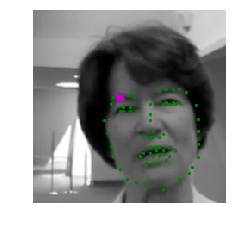

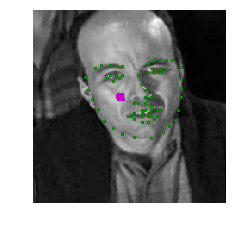

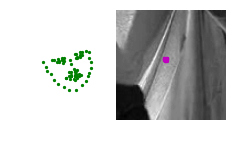

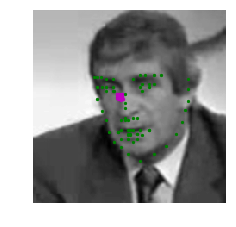

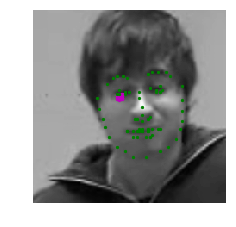

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):
    # prepare the net for training
    net.train()
    
    loss_over_time = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                avg_loss = running_loss/10
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i + 1, avg_loss))
                loss_over_time.append(avg_loss)
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [15]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    training_loss = train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.22586928606033324
Epoch: 1, Batch: 20, Avg. Loss: 0.16178262010216712
Epoch: 1, Batch: 30, Avg. Loss: 0.1409983143210411
Epoch: 1, Batch: 40, Avg. Loss: 0.11150932908058167
Epoch: 1, Batch: 50, Avg. Loss: 0.1347385011613369
Epoch: 1, Batch: 60, Avg. Loss: 0.1141163595020771
Epoch: 1, Batch: 70, Avg. Loss: 0.09331281557679176
Epoch: 1, Batch: 80, Avg. Loss: 0.11024597696959973
Epoch: 1, Batch: 90, Avg. Loss: 0.11268303617835045
Epoch: 1, Batch: 100, Avg. Loss: 0.1042563758790493
Epoch: 1, Batch: 110, Avg. Loss: 0.08738952241837979
Epoch: 1, Batch: 120, Avg. Loss: 0.08960103690624237
Epoch: 1, Batch: 130, Avg. Loss: 0.07606225274503231
Epoch: 1, Batch: 140, Avg. Loss: 0.09631773754954338
Epoch: 1, Batch: 150, Avg. Loss: 0.09887708574533463
Epoch: 1, Batch: 160, Avg. Loss: 0.09147843569517136
Epoch: 1, Batch: 170, Avg. Loss: 0.10003422200679779
Epoch: 1, Batch: 180, Avg. Loss: 0.10750085525214673
Epoch: 1, Batch: 190, Avg. Loss: 0.09290644153952599
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.09348177164793015
Epoch: 2, Batch: 20, Avg. Loss: 0.07734916284680367
Epoch: 2, Batch: 30, Avg. Loss: 0.08186411559581756
Epoch: 2, Batch: 40, Avg. Loss: 0.10022063292562962
Epoch: 2, Batch: 50, Avg. Loss: 0.0938876710832119
Epoch: 2, Batch: 60, Avg. Loss: 0.09684946537017822
Epoch: 2, Batch: 70, Avg. Loss: 0.08995448611676693
Epoch: 2, Batch: 80, Avg. Loss: 0.08661989271640777
Epoch: 2, Batch: 90, Avg. Loss: 0.07566028498113156
Epoch: 2, Batch: 100, Avg. Loss: 0.0838810246437788
Epoch: 2, Batch: 110, Avg. Loss: 0.07531407549977302
Epoch: 2, Batch: 120, Avg. Loss: 0.07816294655203819
Epoch: 2, Batch: 130, Avg. Loss: 0.08137360960245132
Epoch: 2, Batch: 140, Avg. Loss: 0.10402602590620517
Epoch: 2, Batch: 150, Avg. Loss: 0.09478638246655464
Epoch: 2, Batch: 160, Avg. Loss: 0.09251927584409714
Epoch: 2, Batch: 170, Avg. Loss: 0.10869016982614994
Epoch: 2, Batch: 180, Avg. Loss: 0.08406396061182023
Epoch: 2, Batch: 190, Avg. Loss: 0.08111181370913982
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.08574321083724498
Epoch: 3, Batch: 20, Avg. Loss: 0.06339958049356938
Epoch: 3, Batch: 30, Avg. Loss: 0.061392315104603766
Epoch: 3, Batch: 40, Avg. Loss: 0.07551789619028568
Epoch: 3, Batch: 50, Avg. Loss: 0.06967725120484829
Epoch: 3, Batch: 60, Avg. Loss: 0.07901969887316226
Epoch: 3, Batch: 70, Avg. Loss: 0.08289301581680775
Epoch: 3, Batch: 80, Avg. Loss: 0.06848790049552918
Epoch: 3, Batch: 90, Avg. Loss: 0.08159462399780751
Epoch: 3, Batch: 100, Avg. Loss: 0.06681745611131192
Epoch: 3, Batch: 110, Avg. Loss: 0.06938103400170803
Epoch: 3, Batch: 120, Avg. Loss: 0.07083893194794655
Epoch: 3, Batch: 130, Avg. Loss: 0.07650799863040447
Epoch: 3, Batch: 140, Avg. Loss: 0.07115754000842571
Epoch: 3, Batch: 150, Avg. Loss: 0.07944928519427777
Epoch: 3, Batch: 160, Avg. Loss: 0.06253612525761128
Epoch: 3, Batch: 170, Avg. Loss: 0.055241843685507774
Epoch: 3, Batch: 180, Avg. Loss: 0.0687345378100872
Epoch: 3, Batch: 190, Avg. Loss: 0.07427541352808475
E

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.07365094646811485
Epoch: 4, Batch: 20, Avg. Loss: 0.06215356551110744
Epoch: 4, Batch: 30, Avg. Loss: 0.06126847676932812
Epoch: 4, Batch: 40, Avg. Loss: 0.0772283311933279
Epoch: 4, Batch: 50, Avg. Loss: 0.06631959378719329
Epoch: 4, Batch: 60, Avg. Loss: 0.06595512814819812
Epoch: 4, Batch: 70, Avg. Loss: 0.05686250552535057
Epoch: 4, Batch: 80, Avg. Loss: 0.07290070466697215
Epoch: 4, Batch: 90, Avg. Loss: 0.07078402787446976
Epoch: 4, Batch: 100, Avg. Loss: 0.06378421988338231
Epoch: 4, Batch: 110, Avg. Loss: 0.06646374464035035
Epoch: 4, Batch: 120, Avg. Loss: 0.05547263640910387
Epoch: 4, Batch: 130, Avg. Loss: 0.06757797710597516
Epoch: 4, Batch: 140, Avg. Loss: 0.07666652090847492
Epoch: 4, Batch: 150, Avg. Loss: 0.08099088408052921
Epoch: 4, Batch: 160, Avg. Loss: 0.08509804680943489
Epoch: 4, Batch: 170, Avg. Loss: 0.07160098757594824
Epoch: 4, Batch: 180, Avg. Loss: 0.06878651343286038
Epoch: 4, Batch: 190, Avg. Loss: 0.07432313449680805
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.05963290631771088
Epoch: 5, Batch: 20, Avg. Loss: 0.06017531082034111
Epoch: 5, Batch: 30, Avg. Loss: 0.06131524071097374
Epoch: 5, Batch: 40, Avg. Loss: 0.07228882275521756
Epoch: 5, Batch: 50, Avg. Loss: 0.0602884279564023
Epoch: 5, Batch: 60, Avg. Loss: 0.07117623016238213
Epoch: 5, Batch: 70, Avg. Loss: 0.07337065860629081
Epoch: 5, Batch: 80, Avg. Loss: 0.05742347072809935
Epoch: 5, Batch: 90, Avg. Loss: 0.06621726118028164
Epoch: 5, Batch: 100, Avg. Loss: 0.06158871613442898
Epoch: 5, Batch: 110, Avg. Loss: 0.06425998397171498
Epoch: 5, Batch: 120, Avg. Loss: 0.07881503142416477
Epoch: 5, Batch: 130, Avg. Loss: 0.055911066755652425
Epoch: 5, Batch: 140, Avg. Loss: 0.053840023651719096
Epoch: 5, Batch: 150, Avg. Loss: 0.07527646906673909
Epoch: 5, Batch: 160, Avg. Loss: 0.0633412128314376
Epoch: 5, Batch: 170, Avg. Loss: 0.06223057247698307
Epoch: 5, Batch: 180, Avg. Loss: 0.057336782664060594
Epoch: 5, Batch: 190, Avg. Loss: 0.06376631148159503
E

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.06557249501347542
Epoch: 6, Batch: 20, Avg. Loss: 0.06858405135571957
Epoch: 6, Batch: 30, Avg. Loss: 0.05311341099441051
Epoch: 6, Batch: 40, Avg. Loss: 0.057033633999526503
Epoch: 6, Batch: 50, Avg. Loss: 0.06560651883482933
Epoch: 6, Batch: 60, Avg. Loss: 0.07026003859937191
Epoch: 6, Batch: 70, Avg. Loss: 0.08553622104227543
Epoch: 6, Batch: 80, Avg. Loss: 0.06967775411903858
Epoch: 6, Batch: 90, Avg. Loss: 0.057307487912476064
Epoch: 6, Batch: 100, Avg. Loss: 0.05651630386710167
Epoch: 6, Batch: 110, Avg. Loss: 0.058184707351028916
Epoch: 6, Batch: 120, Avg. Loss: 0.04801835231482983
Epoch: 6, Batch: 130, Avg. Loss: 0.07199587188661098
Epoch: 6, Batch: 140, Avg. Loss: 0.07524627819657326
Epoch: 6, Batch: 150, Avg. Loss: 0.06213477980345487
Epoch: 6, Batch: 160, Avg. Loss: 0.06068672258406878
Epoch: 6, Batch: 170, Avg. Loss: 0.07632248811423778
Epoch: 6, Batch: 180, Avg. Loss: 0.05956628434360027
Epoch: 6, Batch: 190, Avg. Loss: 0.06267844624817372

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.05273464880883694
Epoch: 7, Batch: 20, Avg. Loss: 0.06644936576485634
Epoch: 7, Batch: 30, Avg. Loss: 0.04898181147873402
Epoch: 7, Batch: 40, Avg. Loss: 0.07698182240128518
Epoch: 7, Batch: 50, Avg. Loss: 0.03901813142001629
Epoch: 7, Batch: 60, Avg. Loss: 0.05429996829479933
Epoch: 7, Batch: 70, Avg. Loss: 0.06777403205633163
Epoch: 7, Batch: 80, Avg. Loss: 0.06696052215993405
Epoch: 7, Batch: 90, Avg. Loss: 0.048942956142127514
Epoch: 7, Batch: 100, Avg. Loss: 0.0670212160795927
Epoch: 7, Batch: 110, Avg. Loss: 0.05836275853216648
Epoch: 7, Batch: 120, Avg. Loss: 0.06161204017698765
Epoch: 7, Batch: 130, Avg. Loss: 0.0632681017741561
Epoch: 7, Batch: 140, Avg. Loss: 0.05944384206086397
Epoch: 7, Batch: 150, Avg. Loss: 0.06250746101140976
Epoch: 7, Batch: 160, Avg. Loss: 0.07836910486221313
Epoch: 7, Batch: 170, Avg. Loss: 0.06398372873663902
Epoch: 7, Batch: 180, Avg. Loss: 0.05994827263057232
Epoch: 7, Batch: 190, Avg. Loss: 0.06483598388731479
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.057539888098835944
Epoch: 8, Batch: 20, Avg. Loss: 0.05127355381846428
Epoch: 8, Batch: 30, Avg. Loss: 0.06251373253762722
Epoch: 8, Batch: 40, Avg. Loss: 0.06779345069080592
Epoch: 8, Batch: 50, Avg. Loss: 0.04753590300679207
Epoch: 8, Batch: 60, Avg. Loss: 0.05971425585448742
Epoch: 8, Batch: 70, Avg. Loss: 0.06159038431942463
Epoch: 8, Batch: 80, Avg. Loss: 0.08174202330410481
Epoch: 8, Batch: 90, Avg. Loss: 0.07357288487255573
Epoch: 8, Batch: 100, Avg. Loss: 0.0515552194789052
Epoch: 8, Batch: 110, Avg. Loss: 0.07092345766723156
Epoch: 8, Batch: 120, Avg. Loss: 0.0690142361447215
Epoch: 8, Batch: 130, Avg. Loss: 0.05586618930101395
Epoch: 8, Batch: 140, Avg. Loss: 0.061875902116298676
Epoch: 8, Batch: 150, Avg. Loss: 0.05080773271620274
Epoch: 8, Batch: 160, Avg. Loss: 0.05197702031582594
Epoch: 8, Batch: 170, Avg. Loss: 0.0646632755175233
Epoch: 8, Batch: 180, Avg. Loss: 0.05077727530151606
Epoch: 8, Batch: 190, Avg. Loss: 0.05063513405621052
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.05924312155693769
Epoch: 9, Batch: 20, Avg. Loss: 0.06150417104363441
Epoch: 9, Batch: 30, Avg. Loss: 0.04290703125298023
Epoch: 9, Batch: 40, Avg. Loss: 0.059414814598858355
Epoch: 9, Batch: 50, Avg. Loss: 0.05614005774259567
Epoch: 9, Batch: 60, Avg. Loss: 0.05830302741378546
Epoch: 9, Batch: 70, Avg. Loss: 0.05238314233720302
Epoch: 9, Batch: 80, Avg. Loss: 0.0722539022564888
Epoch: 9, Batch: 90, Avg. Loss: 0.0656732153147459
Epoch: 9, Batch: 100, Avg. Loss: 0.03801702167838812
Epoch: 9, Batch: 110, Avg. Loss: 0.047179365158081056
Epoch: 9, Batch: 120, Avg. Loss: 0.06767101250588894
Epoch: 9, Batch: 130, Avg. Loss: 0.050580240041017535
Epoch: 9, Batch: 140, Avg. Loss: 0.07012050338089466
Epoch: 9, Batch: 150, Avg. Loss: 0.06753474529832601
Epoch: 9, Batch: 160, Avg. Loss: 0.04621333051472902
Epoch: 9, Batch: 170, Avg. Loss: 0.05498557724058628
Epoch: 9, Batch: 180, Avg. Loss: 0.053887410834431645
Epoch: 9, Batch: 190, Avg. Loss: 0.053748634085059165

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.0427263680845499
Epoch: 10, Batch: 20, Avg. Loss: 0.046471789851784705
Epoch: 10, Batch: 30, Avg. Loss: 0.045992957428097725
Epoch: 10, Batch: 40, Avg. Loss: 0.05513428039848804
Epoch: 10, Batch: 50, Avg. Loss: 0.044307461380958556
Epoch: 10, Batch: 60, Avg. Loss: 0.07500211298465728
Epoch: 10, Batch: 70, Avg. Loss: 0.06436457373201847
Epoch: 10, Batch: 80, Avg. Loss: 0.05006729383021593
Epoch: 10, Batch: 90, Avg. Loss: 0.0478552708402276
Epoch: 10, Batch: 100, Avg. Loss: 0.051201822608709334
Epoch: 10, Batch: 110, Avg. Loss: 0.047253319248557094
Epoch: 10, Batch: 120, Avg. Loss: 0.048294517956674096
Epoch: 10, Batch: 130, Avg. Loss: 0.07060302328318357
Epoch: 10, Batch: 140, Avg. Loss: 0.060872234776616095
Epoch: 10, Batch: 150, Avg. Loss: 0.06552478149533272
Epoch: 10, Batch: 160, Avg. Loss: 0.07300196178257465
Epoch: 10, Batch: 170, Avg. Loss: 0.058046876825392245
Epoch: 10, Batch: 180, Avg. Loss: 0.050669205747544764
Epoch: 10, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.05061676353216171
Epoch: 11, Batch: 20, Avg. Loss: 0.0454109201207757
Epoch: 11, Batch: 30, Avg. Loss: 0.06642939355224371
Epoch: 11, Batch: 40, Avg. Loss: 0.043451921083033085
Epoch: 11, Batch: 50, Avg. Loss: 0.05587079338729382
Epoch: 11, Batch: 60, Avg. Loss: 0.05729551445692778
Epoch: 11, Batch: 70, Avg. Loss: 0.052514659613370894
Epoch: 11, Batch: 80, Avg. Loss: 0.06826501451432705
Epoch: 11, Batch: 90, Avg. Loss: 0.047094937041401864
Epoch: 11, Batch: 100, Avg. Loss: 0.06338924784213304
Epoch: 11, Batch: 110, Avg. Loss: 0.054787712171673775
Epoch: 11, Batch: 120, Avg. Loss: 0.05562849454581738
Epoch: 11, Batch: 130, Avg. Loss: 0.06471552345901728
Epoch: 11, Batch: 140, Avg. Loss: 0.041167644411325456
Epoch: 11, Batch: 150, Avg. Loss: 0.0622776135802269
Epoch: 11, Batch: 160, Avg. Loss: 0.0574569258838892
Epoch: 11, Batch: 170, Avg. Loss: 0.060204853489995006
Epoch: 11, Batch: 180, Avg. Loss: 0.047503708861768246
Epoch: 11, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.04325293190777302
Epoch: 12, Batch: 20, Avg. Loss: 0.057374329306185246
Epoch: 12, Batch: 30, Avg. Loss: 0.07608969826251269
Epoch: 12, Batch: 40, Avg. Loss: 0.04382892418652773
Epoch: 12, Batch: 50, Avg. Loss: 0.03999165650457144
Epoch: 12, Batch: 60, Avg. Loss: 0.03936189468950033
Epoch: 12, Batch: 70, Avg. Loss: 0.0686236247420311
Epoch: 12, Batch: 80, Avg. Loss: 0.06045791991055012
Epoch: 12, Batch: 90, Avg. Loss: 0.0420869056135416
Epoch: 12, Batch: 100, Avg. Loss: 0.042373164743185046
Epoch: 12, Batch: 110, Avg. Loss: 0.051045657694339754
Epoch: 12, Batch: 120, Avg. Loss: 0.041162272728979585
Epoch: 12, Batch: 130, Avg. Loss: 0.04610598087310791
Epoch: 12, Batch: 140, Avg. Loss: 0.04613997153937817
Epoch: 12, Batch: 150, Avg. Loss: 0.047500197775661945
Epoch: 12, Batch: 160, Avg. Loss: 0.04561188071966171
Epoch: 12, Batch: 170, Avg. Loss: 0.04216049499809742
Epoch: 12, Batch: 180, Avg. Loss: 0.04865196719765663
Epoch: 12, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.03800021130591631
Epoch: 13, Batch: 20, Avg. Loss: 0.051793395355343816
Epoch: 13, Batch: 30, Avg. Loss: 0.04603554531931877
Epoch: 13, Batch: 40, Avg. Loss: 0.0550121258944273
Epoch: 13, Batch: 50, Avg. Loss: 0.0502741351723671
Epoch: 13, Batch: 60, Avg. Loss: 0.044726634956896306
Epoch: 13, Batch: 70, Avg. Loss: 0.047824861109256746
Epoch: 13, Batch: 80, Avg. Loss: 0.06273712404072285
Epoch: 13, Batch: 90, Avg. Loss: 0.05956025794148445
Epoch: 13, Batch: 100, Avg. Loss: 0.052742617391049865
Epoch: 13, Batch: 110, Avg. Loss: 0.048106422461569306
Epoch: 13, Batch: 120, Avg. Loss: 0.04793065283447504
Epoch: 13, Batch: 130, Avg. Loss: 0.045625025406479836
Epoch: 13, Batch: 140, Avg. Loss: 0.04730258528143168
Epoch: 13, Batch: 150, Avg. Loss: 0.047457906417548656
Epoch: 13, Batch: 160, Avg. Loss: 0.05050318222492933
Epoch: 13, Batch: 170, Avg. Loss: 0.05890569873154163
Epoch: 13, Batch: 180, Avg. Loss: 0.04494440481066704
Epoch: 13, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.038136247731745246
Epoch: 14, Batch: 20, Avg. Loss: 0.043095504865050316
Epoch: 14, Batch: 30, Avg. Loss: 0.04564214982092381
Epoch: 14, Batch: 40, Avg. Loss: 0.04890258852392435
Epoch: 14, Batch: 50, Avg. Loss: 0.06177962515503168
Epoch: 14, Batch: 60, Avg. Loss: 0.051409536600112916
Epoch: 14, Batch: 70, Avg. Loss: 0.049777401983737944
Epoch: 14, Batch: 80, Avg. Loss: 0.07039236687123776
Epoch: 14, Batch: 90, Avg. Loss: 0.04258869383484125
Epoch: 14, Batch: 100, Avg. Loss: 0.045317831076681615
Epoch: 14, Batch: 110, Avg. Loss: 0.04187045060098171
Epoch: 14, Batch: 120, Avg. Loss: 0.0477652695029974
Epoch: 14, Batch: 130, Avg. Loss: 0.07375844903290271
Epoch: 14, Batch: 140, Avg. Loss: 0.040193809755146505
Epoch: 14, Batch: 150, Avg. Loss: 0.03951348401606083
Epoch: 14, Batch: 160, Avg. Loss: 0.05760349910706282
Epoch: 14, Batch: 170, Avg. Loss: 0.04394533447921276
Epoch: 14, Batch: 180, Avg. Loss: 0.033510543219745156
Epoch: 14, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.03229462876915932
Epoch: 15, Batch: 20, Avg. Loss: 0.051581164449453355
Epoch: 15, Batch: 30, Avg. Loss: 0.04138043951243162
Epoch: 15, Batch: 40, Avg. Loss: 0.06521434430032969
Epoch: 15, Batch: 50, Avg. Loss: 0.04152621161192656
Epoch: 15, Batch: 60, Avg. Loss: 0.054499107971787454
Epoch: 15, Batch: 70, Avg. Loss: 0.038801207300275566
Epoch: 15, Batch: 80, Avg. Loss: 0.05896623395383358
Epoch: 15, Batch: 90, Avg. Loss: 0.037676777504384515
Epoch: 15, Batch: 100, Avg. Loss: 0.05109384618699551
Epoch: 15, Batch: 110, Avg. Loss: 0.05929310712963343
Epoch: 15, Batch: 120, Avg. Loss: 0.04020221512764692
Epoch: 15, Batch: 130, Avg. Loss: 0.0504709305241704
Epoch: 15, Batch: 140, Avg. Loss: 0.03451139163225889
Epoch: 15, Batch: 150, Avg. Loss: 0.03906440213322639
Epoch: 15, Batch: 160, Avg. Loss: 0.03517405297607183
Epoch: 15, Batch: 170, Avg. Loss: 0.054921087436378004
Epoch: 15, Batch: 180, Avg. Loss: 0.04554178956896067
Epoch: 15, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.04109874200075865
Epoch: 16, Batch: 20, Avg. Loss: 0.04067590981721878
Epoch: 16, Batch: 30, Avg. Loss: 0.0338895158842206
Epoch: 16, Batch: 40, Avg. Loss: 0.04569272696971893
Epoch: 16, Batch: 50, Avg. Loss: 0.042015316896140575
Epoch: 16, Batch: 60, Avg. Loss: 0.04381346143782139
Epoch: 16, Batch: 70, Avg. Loss: 0.04319486152380705
Epoch: 16, Batch: 80, Avg. Loss: 0.0438159191980958
Epoch: 16, Batch: 90, Avg. Loss: 0.038543316535651684
Epoch: 16, Batch: 100, Avg. Loss: 0.03404015973210335
Epoch: 16, Batch: 110, Avg. Loss: 0.04127549892291427
Epoch: 16, Batch: 120, Avg. Loss: 0.04951410330832005
Epoch: 16, Batch: 130, Avg. Loss: 0.04527961816638708
Epoch: 16, Batch: 140, Avg. Loss: 0.03758593145757914
Epoch: 16, Batch: 150, Avg. Loss: 0.037297058291733264
Epoch: 16, Batch: 160, Avg. Loss: 0.041102363634854554
Epoch: 16, Batch: 170, Avg. Loss: 0.05121020637452602
Epoch: 16, Batch: 180, Avg. Loss: 0.037226122431457044
Epoch: 16, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.037560165673494336
Epoch: 17, Batch: 20, Avg. Loss: 0.039327680878341195
Epoch: 17, Batch: 30, Avg. Loss: 0.034604318998754026
Epoch: 17, Batch: 40, Avg. Loss: 0.04557880274951458
Epoch: 17, Batch: 50, Avg. Loss: 0.053306196443736555
Epoch: 17, Batch: 60, Avg. Loss: 0.049857806973159315
Epoch: 17, Batch: 70, Avg. Loss: 0.03268037009984255
Epoch: 17, Batch: 80, Avg. Loss: 0.042219515144824984
Epoch: 17, Batch: 90, Avg. Loss: 0.04170955251902342
Epoch: 17, Batch: 100, Avg. Loss: 0.037877090461552146
Epoch: 17, Batch: 110, Avg. Loss: 0.041641025058925155
Epoch: 17, Batch: 120, Avg. Loss: 0.047610493190586564
Epoch: 17, Batch: 130, Avg. Loss: 0.04895935244858265
Epoch: 17, Batch: 140, Avg. Loss: 0.04195661898702383
Epoch: 17, Batch: 150, Avg. Loss: 0.039191026240587234
Epoch: 17, Batch: 160, Avg. Loss: 0.0373001460917294
Epoch: 17, Batch: 170, Avg. Loss: 0.04629507455974817
Epoch: 17, Batch: 180, Avg. Loss: 0.03507863841950894
Epoch: 17, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.04039545822888613
Epoch: 18, Batch: 20, Avg. Loss: 0.0388639185577631
Epoch: 18, Batch: 30, Avg. Loss: 0.027818835526704788
Epoch: 18, Batch: 40, Avg. Loss: 0.038220609351992604
Epoch: 18, Batch: 50, Avg. Loss: 0.03142477888613939
Epoch: 18, Batch: 60, Avg. Loss: 0.043751733098179105
Epoch: 18, Batch: 70, Avg. Loss: 0.0546279102563858
Epoch: 18, Batch: 80, Avg. Loss: 0.041514260787516834
Epoch: 18, Batch: 90, Avg. Loss: 0.03719558734446764
Epoch: 18, Batch: 100, Avg. Loss: 0.048758438974618915
Epoch: 18, Batch: 110, Avg. Loss: 0.03746445253491402
Epoch: 18, Batch: 120, Avg. Loss: 0.034841582924127576
Epoch: 18, Batch: 130, Avg. Loss: 0.04247723389416933
Epoch: 18, Batch: 140, Avg. Loss: 0.04454488884657622
Epoch: 18, Batch: 150, Avg. Loss: 0.03618251848965883
Epoch: 18, Batch: 160, Avg. Loss: 0.04525383412837982
Epoch: 18, Batch: 170, Avg. Loss: 0.04532912969589233
Epoch: 18, Batch: 180, Avg. Loss: 0.03160274047404528
Epoch: 18, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.04282875079661608
Epoch: 19, Batch: 20, Avg. Loss: 0.03833041749894619
Epoch: 19, Batch: 30, Avg. Loss: 0.034953622985631226
Epoch: 19, Batch: 40, Avg. Loss: 0.03573834579437971
Epoch: 19, Batch: 50, Avg. Loss: 0.029304466024041177
Epoch: 19, Batch: 60, Avg. Loss: 0.056430487614125016
Epoch: 19, Batch: 70, Avg. Loss: 0.03640365647152066
Epoch: 19, Batch: 80, Avg. Loss: 0.0490643578581512
Epoch: 19, Batch: 90, Avg. Loss: 0.0322385074570775
Epoch: 19, Batch: 100, Avg. Loss: 0.03447041902691126
Epoch: 19, Batch: 110, Avg. Loss: 0.04070356823503971
Epoch: 19, Batch: 120, Avg. Loss: 0.03404504992067814
Epoch: 19, Batch: 130, Avg. Loss: 0.03115263571962714
Epoch: 19, Batch: 140, Avg. Loss: 0.027342276833951473
Epoch: 19, Batch: 150, Avg. Loss: 0.033789556473493576
Epoch: 19, Batch: 160, Avg. Loss: 0.03511670529842377
Epoch: 19, Batch: 170, Avg. Loss: 0.051254578307271
Epoch: 19, Batch: 180, Avg. Loss: 0.03437401410192251
Epoch: 19, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.02544662104919553
Epoch: 20, Batch: 20, Avg. Loss: 0.0322669243440032
Epoch: 20, Batch: 30, Avg. Loss: 0.028290612157434225
Epoch: 20, Batch: 40, Avg. Loss: 0.04885987415909767
Epoch: 20, Batch: 50, Avg. Loss: 0.0473514249548316
Epoch: 20, Batch: 60, Avg. Loss: 0.024444083962589503
Epoch: 20, Batch: 70, Avg. Loss: 0.030154835246503354
Epoch: 20, Batch: 80, Avg. Loss: 0.033053291216492656
Epoch: 20, Batch: 90, Avg. Loss: 0.027860751654952765
Epoch: 20, Batch: 100, Avg. Loss: 0.039179110620170834
Epoch: 20, Batch: 110, Avg. Loss: 0.027746180538088083
Epoch: 20, Batch: 120, Avg. Loss: 0.027709781657904387
Epoch: 20, Batch: 130, Avg. Loss: 0.05260457471013069
Epoch: 20, Batch: 140, Avg. Loss: 0.03287832997739315
Epoch: 20, Batch: 150, Avg. Loss: 0.03317287601530552
Epoch: 20, Batch: 160, Avg. Loss: 0.034946687147021295
Epoch: 20, Batch: 170, Avg. Loss: 0.023488976620137693
Epoch: 20, Batch: 180, Avg. Loss: 0.03168927915394306
Epoch: 20, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.0446141354739666
Epoch: 21, Batch: 20, Avg. Loss: 0.03859851658344269
Epoch: 21, Batch: 30, Avg. Loss: 0.03804655224084854
Epoch: 21, Batch: 40, Avg. Loss: 0.03522502891719341
Epoch: 21, Batch: 50, Avg. Loss: 0.03931860439479351
Epoch: 21, Batch: 60, Avg. Loss: 0.027837491035461424
Epoch: 21, Batch: 70, Avg. Loss: 0.028058597445487977
Epoch: 21, Batch: 80, Avg. Loss: 0.04693188760429621
Epoch: 21, Batch: 90, Avg. Loss: 0.03149707764387131
Epoch: 21, Batch: 100, Avg. Loss: 0.030720962956547738
Epoch: 21, Batch: 110, Avg. Loss: 0.05049128346145153
Epoch: 21, Batch: 120, Avg. Loss: 0.032473934534937146
Epoch: 21, Batch: 130, Avg. Loss: 0.04882478751242161
Epoch: 21, Batch: 140, Avg. Loss: 0.026748929917812348
Epoch: 21, Batch: 150, Avg. Loss: 0.024047349859029055
Epoch: 21, Batch: 160, Avg. Loss: 0.03502423223108053
Epoch: 21, Batch: 170, Avg. Loss: 0.03913753852248192
Epoch: 21, Batch: 180, Avg. Loss: 0.03897808138281107
Epoch: 21, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.054395243804901836
Epoch: 22, Batch: 20, Avg. Loss: 0.029219949059188365
Epoch: 22, Batch: 30, Avg. Loss: 0.028650907706469296
Epoch: 22, Batch: 40, Avg. Loss: 0.02461265418678522
Epoch: 22, Batch: 50, Avg. Loss: 0.04014389431104064
Epoch: 22, Batch: 60, Avg. Loss: 0.02566874586045742
Epoch: 22, Batch: 70, Avg. Loss: 0.029455929715186357
Epoch: 22, Batch: 80, Avg. Loss: 0.039291707798838615
Epoch: 22, Batch: 90, Avg. Loss: 0.024057198595255614
Epoch: 22, Batch: 100, Avg. Loss: 0.0439784743823111
Epoch: 22, Batch: 110, Avg. Loss: 0.029037579707801343
Epoch: 22, Batch: 120, Avg. Loss: 0.04037431832402945
Epoch: 22, Batch: 130, Avg. Loss: 0.04091968946158886
Epoch: 22, Batch: 140, Avg. Loss: 0.031468530744314195
Epoch: 22, Batch: 150, Avg. Loss: 0.03839863017201424
Epoch: 22, Batch: 160, Avg. Loss: 0.024821590445935727
Epoch: 22, Batch: 170, Avg. Loss: 0.040808391943573954
Epoch: 22, Batch: 180, Avg. Loss: 0.03291635122150183
Epoch: 22, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.03252028319984675
Epoch: 23, Batch: 20, Avg. Loss: 0.026330881752073765
Epoch: 23, Batch: 30, Avg. Loss: 0.025074855983257295
Epoch: 23, Batch: 40, Avg. Loss: 0.030292787496000527
Epoch: 23, Batch: 50, Avg. Loss: 0.02556143943220377
Epoch: 23, Batch: 60, Avg. Loss: 0.038477192260324956
Epoch: 23, Batch: 70, Avg. Loss: 0.02983083613216877
Epoch: 23, Batch: 80, Avg. Loss: 0.02476016478613019
Epoch: 23, Batch: 90, Avg. Loss: 0.02416811939328909
Epoch: 23, Batch: 100, Avg. Loss: 0.0361682802438736
Epoch: 23, Batch: 110, Avg. Loss: 0.0277385376393795
Epoch: 23, Batch: 120, Avg. Loss: 0.027981392480432986
Epoch: 23, Batch: 130, Avg. Loss: 0.05491126999258995
Epoch: 23, Batch: 140, Avg. Loss: 0.0293274549767375
Epoch: 23, Batch: 150, Avg. Loss: 0.07285809647291899
Epoch: 23, Batch: 160, Avg. Loss: 0.02981123123317957
Epoch: 23, Batch: 170, Avg. Loss: 0.030775728914886714
Epoch: 23, Batch: 180, Avg. Loss: 0.03357632765546441
Epoch: 23, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.03152178749442101
Epoch: 24, Batch: 20, Avg. Loss: 0.02764024315401912
Epoch: 24, Batch: 30, Avg. Loss: 0.02162907663732767
Epoch: 24, Batch: 40, Avg. Loss: 0.030070379190146924
Epoch: 24, Batch: 50, Avg. Loss: 0.026882947143167257
Epoch: 24, Batch: 60, Avg. Loss: 0.024578813463449478
Epoch: 24, Batch: 70, Avg. Loss: 0.041316216252744196
Epoch: 24, Batch: 80, Avg. Loss: 0.02787378169596195
Epoch: 24, Batch: 90, Avg. Loss: 0.024798912554979326
Epoch: 24, Batch: 100, Avg. Loss: 0.02536426531150937
Epoch: 24, Batch: 110, Avg. Loss: 0.04591753082349896
Epoch: 24, Batch: 120, Avg. Loss: 0.028452633321285246
Epoch: 24, Batch: 130, Avg. Loss: 0.0262349221855402
Epoch: 24, Batch: 140, Avg. Loss: 0.03744669994339347
Epoch: 24, Batch: 150, Avg. Loss: 0.02631586855277419
Epoch: 24, Batch: 160, Avg. Loss: 0.03411305202171207
Epoch: 24, Batch: 170, Avg. Loss: 0.020312060415744782
Epoch: 24, Batch: 180, Avg. Loss: 0.04297229722142219
Epoch: 24, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.03016777243465185
Epoch: 25, Batch: 20, Avg. Loss: 0.024848702363669872
Epoch: 25, Batch: 30, Avg. Loss: 0.058219189289957285
Epoch: 25, Batch: 40, Avg. Loss: 0.03603382632136345
Epoch: 25, Batch: 50, Avg. Loss: 0.04314085328951478
Epoch: 25, Batch: 60, Avg. Loss: 0.03090058621019125
Epoch: 25, Batch: 70, Avg. Loss: 0.04196107285097241
Epoch: 25, Batch: 80, Avg. Loss: 0.029186677001416684
Epoch: 25, Batch: 90, Avg. Loss: 0.028372990433126688
Epoch: 25, Batch: 100, Avg. Loss: 0.024793827161192893
Epoch: 25, Batch: 110, Avg. Loss: 0.037733154743909834
Epoch: 25, Batch: 120, Avg. Loss: 0.02934939190745354
Epoch: 25, Batch: 130, Avg. Loss: 0.03948429925367236
Epoch: 25, Batch: 140, Avg. Loss: 0.02129462780430913
Epoch: 25, Batch: 150, Avg. Loss: 0.028354244865477087
Epoch: 25, Batch: 160, Avg. Loss: 0.029366175644099712
Epoch: 25, Batch: 170, Avg. Loss: 0.026944221276789904
Epoch: 25, Batch: 180, Avg. Loss: 0.022061697207391262
Epoch: 25, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.028854743763804435
Epoch: 26, Batch: 20, Avg. Loss: 0.04046886507421732
Epoch: 26, Batch: 30, Avg. Loss: 0.035453150421380995
Epoch: 26, Batch: 40, Avg. Loss: 0.02691229758784175
Epoch: 26, Batch: 50, Avg. Loss: 0.0362893471494317
Epoch: 26, Batch: 60, Avg. Loss: 0.023481403943151236
Epoch: 26, Batch: 70, Avg. Loss: 0.029266020748764277
Epoch: 26, Batch: 80, Avg. Loss: 0.023223257437348366
Epoch: 26, Batch: 90, Avg. Loss: 0.04109567543491721
Epoch: 26, Batch: 100, Avg. Loss: 0.03414567103609443
Epoch: 26, Batch: 110, Avg. Loss: 0.020564076490700245
Epoch: 26, Batch: 120, Avg. Loss: 0.024953780230134726
Epoch: 26, Batch: 130, Avg. Loss: 0.026321571227163075
Epoch: 26, Batch: 140, Avg. Loss: 0.036731773614883424
Epoch: 26, Batch: 150, Avg. Loss: 0.030748135410249233
Epoch: 26, Batch: 160, Avg. Loss: 0.025771495327353476
Epoch: 26, Batch: 170, Avg. Loss: 0.03964887810871005
Epoch: 26, Batch: 180, Avg. Loss: 0.037149651907384396
Epoch: 26, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.02170921294018626
Epoch: 27, Batch: 20, Avg. Loss: 0.028799652121961117
Epoch: 27, Batch: 30, Avg. Loss: 0.046343916282057765
Epoch: 27, Batch: 40, Avg. Loss: 0.023746291641145945
Epoch: 27, Batch: 50, Avg. Loss: 0.0322376249358058
Epoch: 27, Batch: 60, Avg. Loss: 0.040318386442959306
Epoch: 27, Batch: 70, Avg. Loss: 0.03422957751899958
Epoch: 27, Batch: 80, Avg. Loss: 0.024088332429528236
Epoch: 27, Batch: 90, Avg. Loss: 0.03338491963222623
Epoch: 27, Batch: 100, Avg. Loss: 0.035601606406271455
Epoch: 27, Batch: 110, Avg. Loss: 0.020868857204914094
Epoch: 27, Batch: 120, Avg. Loss: 0.02476738654077053
Epoch: 27, Batch: 130, Avg. Loss: 0.0223910728469491
Epoch: 27, Batch: 140, Avg. Loss: 0.02246272386983037
Epoch: 27, Batch: 150, Avg. Loss: 0.030084090027958154
Epoch: 27, Batch: 160, Avg. Loss: 0.035680713783949616
Epoch: 27, Batch: 170, Avg. Loss: 0.03218111013993621
Epoch: 27, Batch: 180, Avg. Loss: 0.02613999405875802
Epoch: 27, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.02036066921427846
Epoch: 28, Batch: 20, Avg. Loss: 0.02661367189139128
Epoch: 28, Batch: 30, Avg. Loss: 0.021559723652899265
Epoch: 28, Batch: 40, Avg. Loss: 0.022188319731503724
Epoch: 28, Batch: 50, Avg. Loss: 0.022233745362609626
Epoch: 28, Batch: 60, Avg. Loss: 0.023172825668007137
Epoch: 28, Batch: 70, Avg. Loss: 0.020256060361862182
Epoch: 28, Batch: 80, Avg. Loss: 0.027562351338565348
Epoch: 28, Batch: 90, Avg. Loss: 0.0374516773968935
Epoch: 28, Batch: 100, Avg. Loss: 0.04832094982266426
Epoch: 28, Batch: 110, Avg. Loss: 0.019349658209830523
Epoch: 28, Batch: 120, Avg. Loss: 0.023339619860053062
Epoch: 28, Batch: 130, Avg. Loss: 0.025982008408755065
Epoch: 28, Batch: 140, Avg. Loss: 0.03464273856952786
Epoch: 28, Batch: 150, Avg. Loss: 0.02894100286066532
Epoch: 28, Batch: 160, Avg. Loss: 0.028478223457932474
Epoch: 28, Batch: 170, Avg. Loss: 0.03631578478962183
Epoch: 28, Batch: 180, Avg. Loss: 0.03140123058110476
Epoch: 28, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.021448119170963766
Epoch: 29, Batch: 20, Avg. Loss: 0.02275498826056719
Epoch: 29, Batch: 30, Avg. Loss: 0.02465443778783083
Epoch: 29, Batch: 40, Avg. Loss: 0.03241304187104106
Epoch: 29, Batch: 50, Avg. Loss: 0.02813016381114721
Epoch: 29, Batch: 60, Avg. Loss: 0.026159814465790986
Epoch: 29, Batch: 70, Avg. Loss: 0.022744703013449906
Epoch: 29, Batch: 80, Avg. Loss: 0.03789746668189764
Epoch: 29, Batch: 90, Avg. Loss: 0.019624606333673
Epoch: 29, Batch: 100, Avg. Loss: 0.025542842876166105
Epoch: 29, Batch: 110, Avg. Loss: 0.01967744892463088
Epoch: 29, Batch: 120, Avg. Loss: 0.029791803751140832
Epoch: 29, Batch: 130, Avg. Loss: 0.025372335314750673
Epoch: 29, Batch: 140, Avg. Loss: 0.02633567191660404
Epoch: 29, Batch: 150, Avg. Loss: 0.025100601371377707
Epoch: 29, Batch: 160, Avg. Loss: 0.021305006556212903
Epoch: 29, Batch: 170, Avg. Loss: 0.023089042585343122
Epoch: 29, Batch: 180, Avg. Loss: 0.02935681790113449
Epoch: 29, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.019871354289352893
Epoch: 30, Batch: 20, Avg. Loss: 0.021399842482060193
Epoch: 30, Batch: 30, Avg. Loss: 0.0321511899586767
Epoch: 30, Batch: 40, Avg. Loss: 0.031344080716371535
Epoch: 30, Batch: 50, Avg. Loss: 0.01894573923200369
Epoch: 30, Batch: 60, Avg. Loss: 0.025085412710905076
Epoch: 30, Batch: 70, Avg. Loss: 0.025776030449196696
Epoch: 30, Batch: 80, Avg. Loss: 0.026591306179761888
Epoch: 30, Batch: 90, Avg. Loss: 0.024410826433449984
Epoch: 30, Batch: 100, Avg. Loss: 0.028626745101064444
Epoch: 30, Batch: 110, Avg. Loss: 0.022735116071999073
Epoch: 30, Batch: 120, Avg. Loss: 0.026209793426096438
Epoch: 30, Batch: 130, Avg. Loss: 0.028601964004337788
Epoch: 30, Batch: 140, Avg. Loss: 0.03435403928160667
Epoch: 30, Batch: 150, Avg. Loss: 0.03640105370432138
Epoch: 30, Batch: 160, Avg. Loss: 0.03222393924370408
Epoch: 30, Batch: 170, Avg. Loss: 0.026589342579245567
Epoch: 30, Batch: 180, Avg. Loss: 0.029753433354198933
Epoch: 30, Batch: 190, Av

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


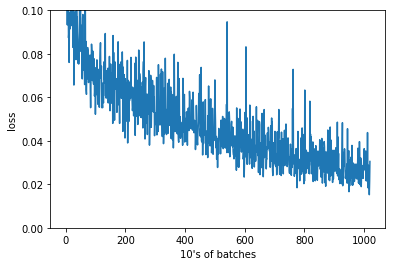

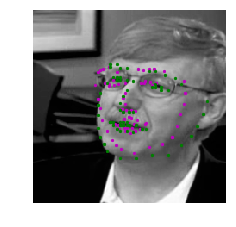

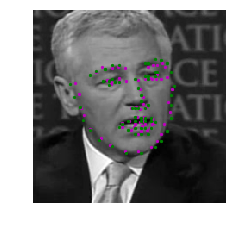

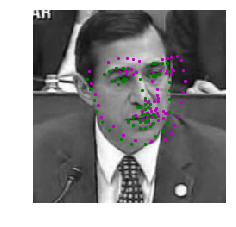

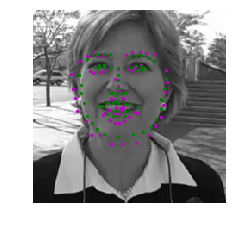

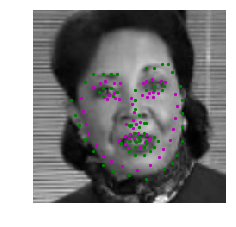

In [23]:
plt.plot(training_loss)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 0.1) # consistent scale
plt.show()

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [24]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:
- Adam optimization. So far it is the most popular algorithm, which combines the advanteges from SGD, RMSProp and AdaGrad.

- SmoothL1Loss function. It was recommended to use one of the functions (MSE or L1/SmoothL1 loss). After some experiments this function was chosen.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I had other problem to get a stable reduced loss. I read the recommended research paper and decided to make something, that a little bit easier ist, but it was not possible to run it in udacity workspace. I implemented less filter channels and it is the bestr result sofar.
I didn't see the overfitting. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:
- The problem is in time and resources limit. Since we don't use GPU, I decided to use the batch size 64 instead 128 (as recommented in the paper). It is still a power of 2, but a little bit less. But after compare, the result for the 5 epochs is better for 10 batches size, as for 64.
- For the best result it schould be much more epochs, like 300. It should be possible to see by results, how much training gives the advantages.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.03880962 -0.00435812  0.19547279  0.07757917]
 [ 0.09079849  0.06065684  0.18807246 -0.14942901]
 [-0.0748158   0.06228452 -0.05850144 -0.00859566]
 [ 0.14946786  0.10434137 -0.0096894   0.13024893]]
(4, 4)


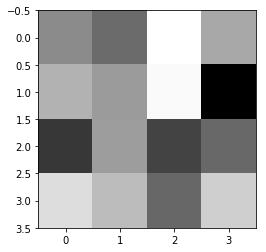

In [25]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 2

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

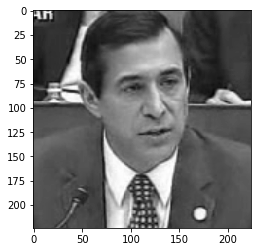

In [26]:
## load in and display any image from the transformed test dataset
image = test_images[filter_index].data   # get the image from it's wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
plt.imshow(np.squeeze(image), cmap='gray')

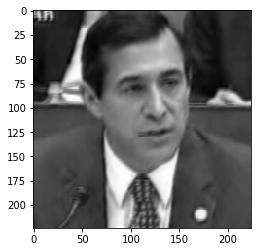

In [27]:
## Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

filtered = cv2.filter2D(image, -1, w[filter_index][0])
plt.imshow(filtered, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It looks like inverted colors. The dark parts are the brightest. Possible it detects a person area.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!